# STYLE-ALIGNED WITH REFERENCE IMAGE

In [1]:
# Clone the repository
!git clone https://github.com/alessioborgi/StyleAlignedDiffModels.git

# Change directory to the cloned repository
%cd StyleAlignedDiffModels
%ls

# Set up Git configuration
!git config --global user.name "Alessio Borgi"
!git config --global user.email "alessioborgi3@gmail.com"

# Stage the changes
#!git add .

# Commit the changes
#!git commit -m "Added some content to your-file.txt"

# Push the changes (replace 'your-token' with your actual personal access token)
#!git push origin main

Cloning into 'StyleAlignedDiffModels'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 91 (delta 44), reused 42 (delta 13), pack-reused 0
Receiving objects: 100% (91/91), 9.65 MiB | 10.88 MiB/s, done.
Resolving deltas: 100% (44/44), done.
/content/StyleAlignedDiffModels
imgs/         README.md         src/                            Style_Aligned_Transfer_SDXL.ipynb
inversion.py  requirements.txt  StyleAligned_Explanation.ipynb  TO-DO.txt
LICENSE       sa_handler.py     Style_Aligned_SDXL_old.ipynb


In [2]:
# Install the required packages
!pip install -r requirements.txt > /dev/null

In [ ]:
import copy
import torch
import einops
import mediapy
import numpy as np
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
from typing import Any
from typing import Callable
from dataclasses import dataclass
from __future__ import annotations
from diffusers.utils import load_image
from torch.nn import functional as nnf
from diffusers.models import attention_processor
from diffusers.image_processor import PipelineImageInput
from transformers import DPTImageProcessor, DPTForDepthEstimation
from diffusers.utils.torch_utils import is_compiled_module, is_torch_version
from diffusers import StableDiffusionXLPipeline, DDIMScheduler, ControlNetModel, StableDiffusionXLControlNetPipeline, AutoencoderKL

T = torch.tensor # Create Alias for torch.tensor to increase readability.
TN = T

#### Model Load

In [3]:
from diffusers import StableDiffusionXLPipeline, DDIMScheduler
import torch
import mediapy
import sa_handler
import math


scheduler = DDIMScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False)

pipeline = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
    scheduler=scheduler
).to("cuda")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

#### Ref image load and inversion

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 50/50 [00:18<00:00,  2.72it/s]



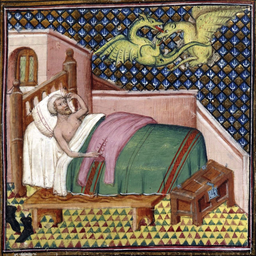

In [4]:
# DDIM inversion
from diffusers.utils import load_image
import inversion
import numpy as np

src_style = "medieval painting"
src_prompt = f'Man laying in a bed, {src_style}.'
image_path = './imgs/medieval-bed.jpeg'

num_inference_steps = 50
x0 = np.array(load_image(image_path).resize((1024, 1024)))
zts = inversion.ddim_inversion(pipeline, x0, src_prompt, num_inference_steps, 2)
mediapy.show_image(x0, title="innput reference image", height=256)

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 4.00 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 8.00 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 8.01 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an 


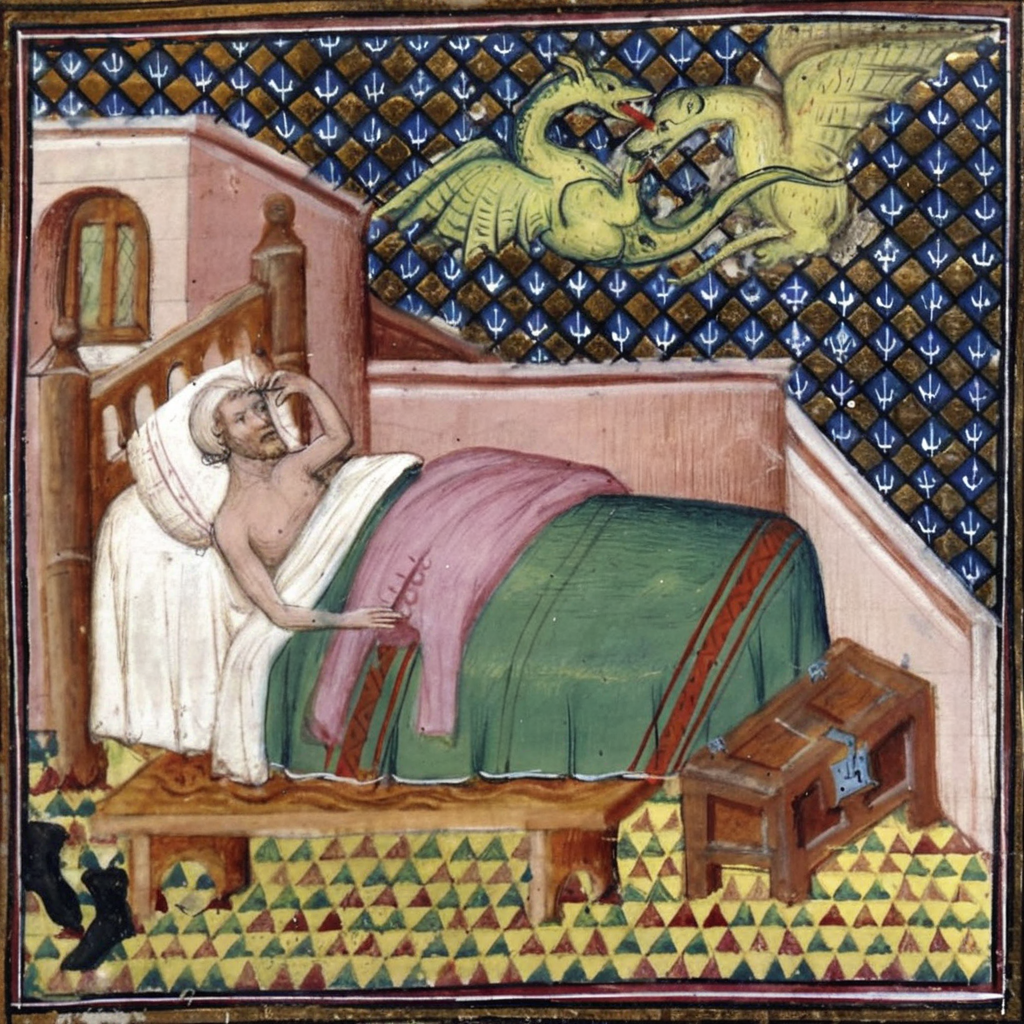
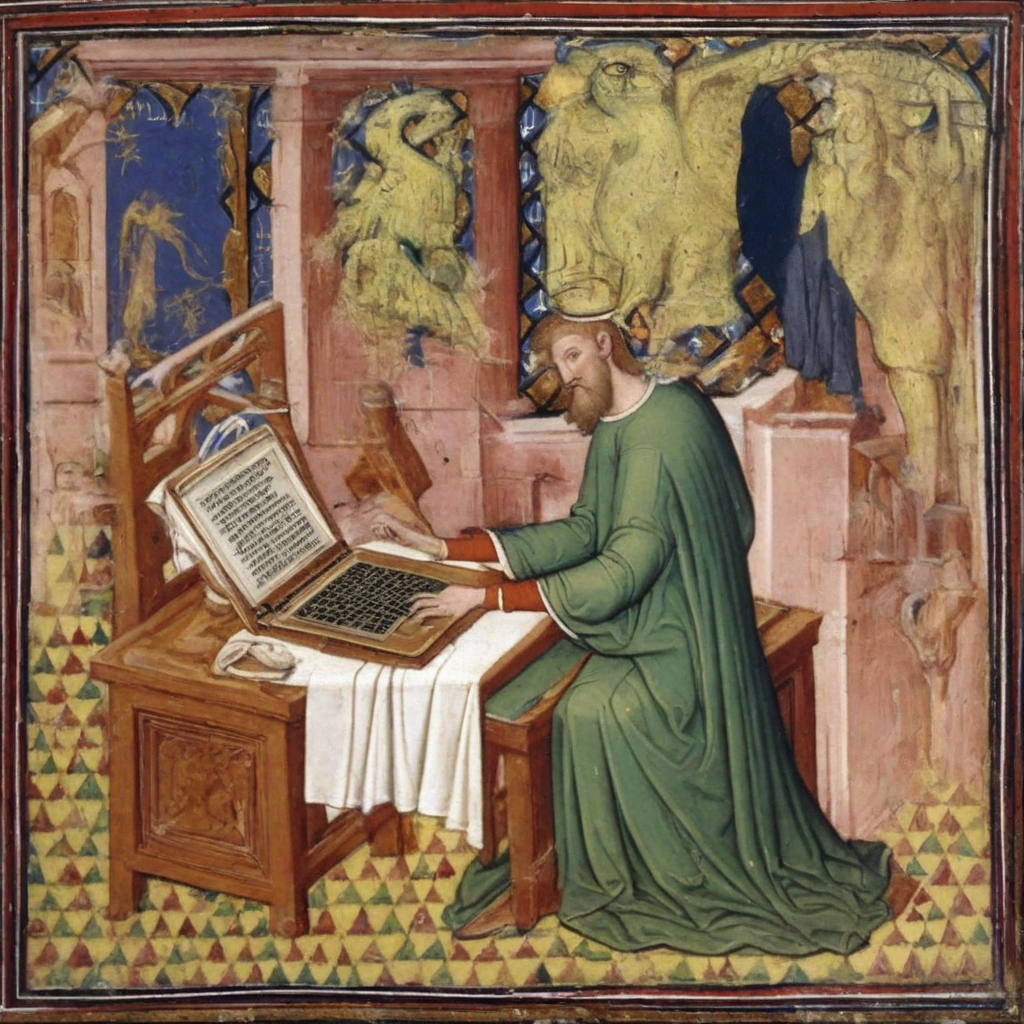
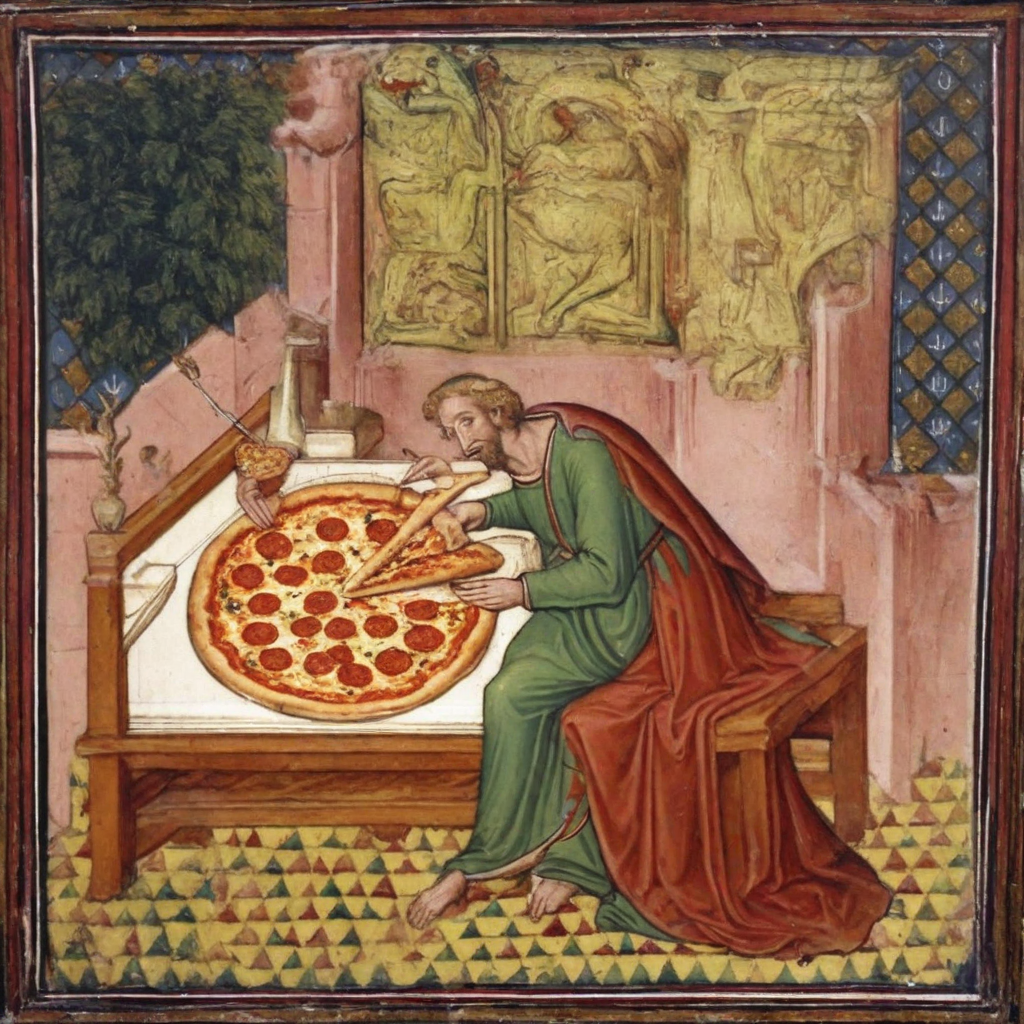
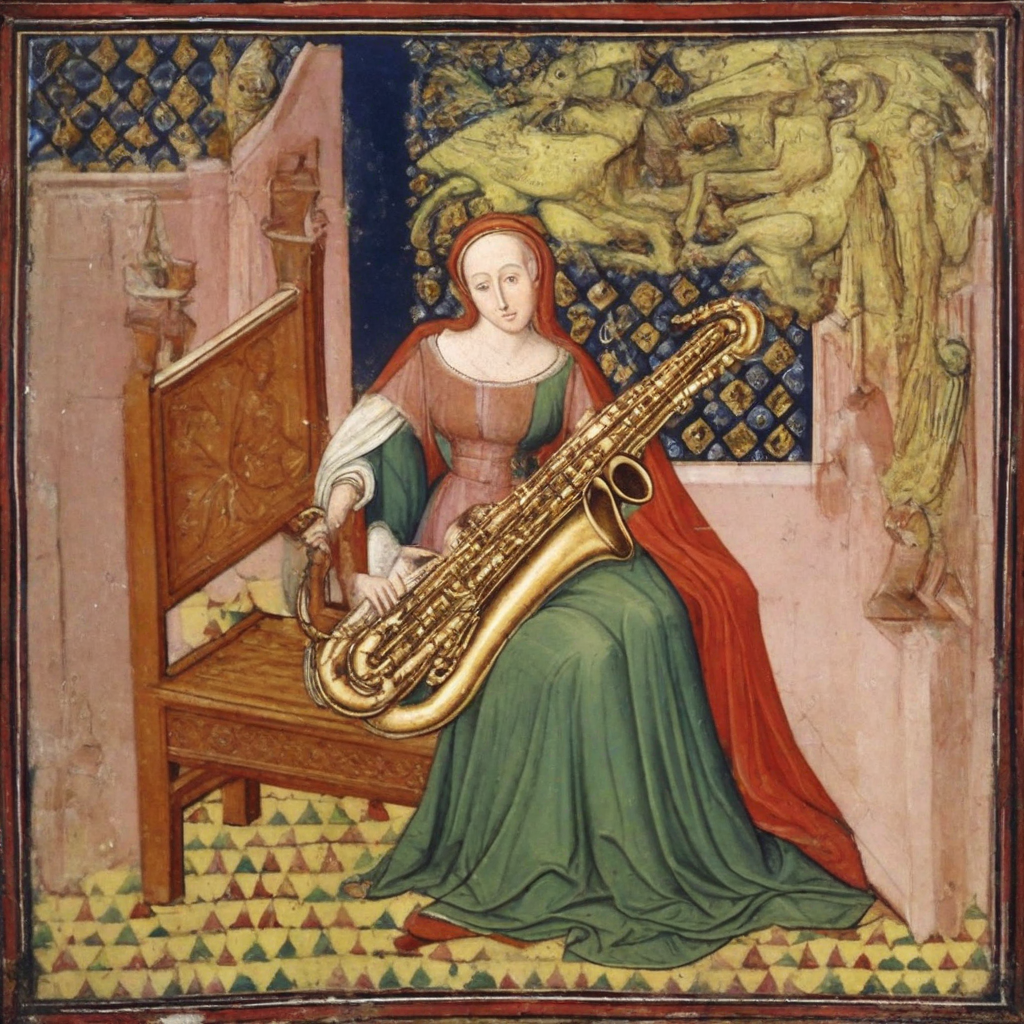

In [5]:
prompts = [
    src_prompt,
    "A man working on a laptop",
    "A man eats pizza",
    "A woman playig on saxophone",
]

# some parameters you can adjust to control fidelity to reference
shared_score_shift = np.log(2)  # higher value induces higher fidelity, set 0 for no shift
shared_score_scale = 1.0  # higher value induces higher, set 1 for no rescale

# for very famouse images consider supressing attention to reference, here is a configuration example:
# shared_score_shift = np.log(1)
# shared_score_scale = 0.5

for i in range(1, len(prompts)):
    prompts[i] = f'{prompts[i]}, {src_style}.'

handler = sa_handler.Handler(pipeline)
sa_args = sa_handler.StyleAlignedArgs(
    share_group_norm=True,
    share_layer_norm=True,
    share_attention=True,
    adain_queries=True,
    adain_keys=True,
    adain_values=False,
    shared_score_shift=shared_score_shift,
    shared_score_scale=shared_score_scale)
handler.register(sa_args)

zT, inversion_callback = inversion.make_inversion_callback(zts, offset=5)

g_cpu = torch.Generator(device='cpu')
g_cpu.manual_seed(10)

latents = torch.randn(len(prompts), 4, 128, 128, device='cpu', generator=g_cpu,
                      dtype=pipeline.unet.dtype,).to('cuda:0')
latents[0] = zT

images_a = pipeline(prompts, latents=latents,
                    callback_on_step_end=inversion_callback,
                    num_inference_steps=num_inference_steps, guidance_scale=10.0).images

handler.remove()
mediapy.show_images(images_a, titles=[p[:-(len(src_style) + 3)] for p in prompts])